In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt


2024-08-12 15:07:34.539884: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 15:07:34.540033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 15:07:34.672969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 **Define the Dataset and Preprocessing
We'll use the MNIST dataset **

In [2]:
# Load the dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the dataset to the range [-1, 1]
x_train = (x_train - 127.5) / 127.5
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

# Create a data loader
batch_size = 64
buffer_size = 60000
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28, 1)

**Define the Generator Network**

In [4]:
def build_generator():
    model = models.Sequential()
    
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.ReLU())
    model.add(layers.Dense(512))
    model.add(layers.ReLU())
    model.add(layers.Dense(1024))
    model.add(layers.ReLU())
    model.add(layers.Dense(28*28*1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    
    return model

generator = build_generator()
generator.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,486,352 (5.67 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

**Define Discriminator Network**

In [5]:
def build_discriminator():
    model = models.Sequential()
    
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

discriminator = build_discriminator()
discriminator.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,460,225 (5.57 MB)

 Trainable params: 1,460,225 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

**Define the Discriminator Network**

In [6]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Discriminator and Generator Optimizers
d_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


**Define the Training Functions**

In [7]:
@tf.function
def train_step(real_images):
    noise = tf.random.normal([batch_size, 100])

    # Train the discriminator
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
        fake_images = generator(noise, training=True)
        
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        
        d_loss_real = cross_entropy(tf.ones_like(real_output), real_output)
        d_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        d_loss = d_loss_real + d_loss_fake

        g_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

    return d_loss, g_loss


**Training the GAN**

In [8]:
def train_gan(train_dataset, epochs):
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        for image_batch in train_dataset:
            d_loss, g_loss = train_step(image_batch)

        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
        # Print progress
        print(f'Epoch {epoch+1}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}')

        # Generate and save images after every few epochs
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, tf.random.normal([16, 100]))

    return d_losses, g_losses

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


**Run the Training**

Epoch 1, Discriminator Loss: 0.4344809353351593, Generator Loss: 1.5619748830795288
Epoch 2, Discriminator Loss: 0.8690150380134583, Generator Loss: 8.40851879119873
Epoch 3, Discriminator Loss: 0.02267480455338955, Generator Loss: 4.273643493652344
Epoch 4, Discriminator Loss: 0.047302134335041046, Generator Loss: 3.100778818130493
Epoch 5, Discriminator Loss: 0.9486964344978333, Generator Loss: 1.972505807876587
Epoch 6, Discriminator Loss: 0.08816370368003845, Generator Loss: 2.7254691123962402
Epoch 7, Discriminator Loss: 0.042750515043735504, Generator Loss: 3.268798351287842
Epoch 8, Discriminator Loss: 0.2746371328830719, Generator Loss: 2.1868128776550293
Epoch 9, Discriminator Loss: 0.1831611841917038, Generator Loss: 2.4557864665985107
Epoch 10, Discriminator Loss: 0.21441951394081116, Generator Loss: 5.909529209136963


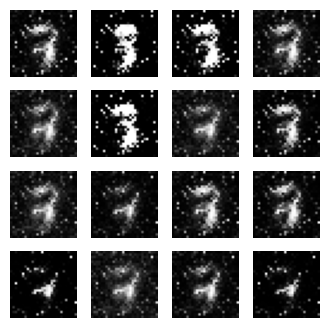

Epoch 11, Discriminator Loss: 0.2813919186592102, Generator Loss: 3.1003780364990234
Epoch 12, Discriminator Loss: 0.2404334545135498, Generator Loss: 2.5422747135162354
Epoch 13, Discriminator Loss: 0.46666955947875977, Generator Loss: 1.5859615802764893
Epoch 14, Discriminator Loss: 0.49083203077316284, Generator Loss: 1.4839556217193604
Epoch 15, Discriminator Loss: 0.7069500684738159, Generator Loss: 2.7055277824401855
Epoch 16, Discriminator Loss: 0.8753446936607361, Generator Loss: 2.5177695751190186
Epoch 17, Discriminator Loss: 0.6280033588409424, Generator Loss: 1.9263982772827148
Epoch 18, Discriminator Loss: 0.785910427570343, Generator Loss: 2.2215986251831055
Epoch 19, Discriminator Loss: 0.7688342332839966, Generator Loss: 1.7002382278442383
Epoch 20, Discriminator Loss: 0.7705855369567871, Generator Loss: 1.255782127380371


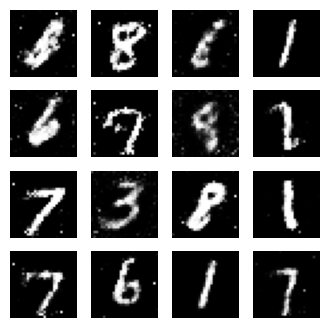

Epoch 21, Discriminator Loss: 0.8064744472503662, Generator Loss: 1.441800594329834
Epoch 22, Discriminator Loss: 0.9536855220794678, Generator Loss: 1.9549604654312134
Epoch 23, Discriminator Loss: 0.929043173789978, Generator Loss: 1.6048388481140137
Epoch 24, Discriminator Loss: 0.8132668733596802, Generator Loss: 1.4314861297607422
Epoch 25, Discriminator Loss: 0.9661068320274353, Generator Loss: 0.9629524946212769
Epoch 26, Discriminator Loss: 0.800929069519043, Generator Loss: 1.6991071701049805
Epoch 27, Discriminator Loss: 1.1333377361297607, Generator Loss: 1.4629875421524048
Epoch 28, Discriminator Loss: 0.952336847782135, Generator Loss: 1.5058581829071045
Epoch 29, Discriminator Loss: 0.6562070846557617, Generator Loss: 1.55308997631073
Epoch 30, Discriminator Loss: 0.8890843391418457, Generator Loss: 1.249042272567749


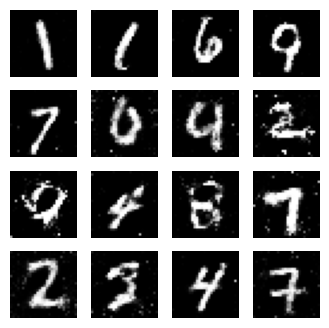

Epoch 31, Discriminator Loss: 1.0992827415466309, Generator Loss: 0.9512094259262085
Epoch 32, Discriminator Loss: 0.9258084893226624, Generator Loss: 1.2597739696502686
Epoch 33, Discriminator Loss: 0.9924437999725342, Generator Loss: 1.3723398447036743
Epoch 34, Discriminator Loss: 1.1301770210266113, Generator Loss: 1.12940514087677
Epoch 35, Discriminator Loss: 1.2268178462982178, Generator Loss: 1.3628191947937012
Epoch 36, Discriminator Loss: 0.9320037364959717, Generator Loss: 1.20041823387146
Epoch 37, Discriminator Loss: 1.1231303215026855, Generator Loss: 0.9934138059616089
Epoch 38, Discriminator Loss: 1.0064187049865723, Generator Loss: 1.3910894393920898
Epoch 39, Discriminator Loss: 0.9487998485565186, Generator Loss: 1.3432323932647705
Epoch 40, Discriminator Loss: 1.266496181488037, Generator Loss: 1.1136744022369385


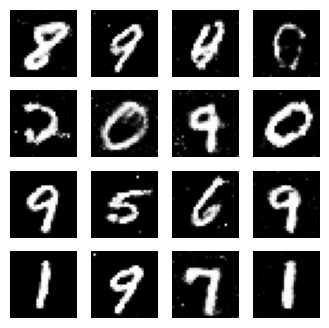

Epoch 41, Discriminator Loss: 1.009164810180664, Generator Loss: 1.328948736190796
Epoch 42, Discriminator Loss: 0.9232689738273621, Generator Loss: 1.1971267461776733
Epoch 43, Discriminator Loss: 1.102543830871582, Generator Loss: 1.0609742403030396
Epoch 44, Discriminator Loss: 1.0444488525390625, Generator Loss: 1.4488801956176758
Epoch 45, Discriminator Loss: 0.8283511400222778, Generator Loss: 1.3012124300003052
Epoch 46, Discriminator Loss: 0.9947110414505005, Generator Loss: 1.4621844291687012
Epoch 47, Discriminator Loss: 1.3342701196670532, Generator Loss: 1.5458312034606934
Epoch 48, Discriminator Loss: 1.1393613815307617, Generator Loss: 1.1034212112426758
Epoch 49, Discriminator Loss: 1.1669007539749146, Generator Loss: 1.4612127542495728
Epoch 50, Discriminator Loss: 1.093249797821045, Generator Loss: 1.2000055313110352


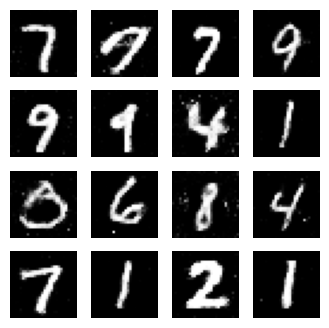

In [9]:
epochs = 50
d_losses, g_losses = train_gan(train_dataset, epochs)


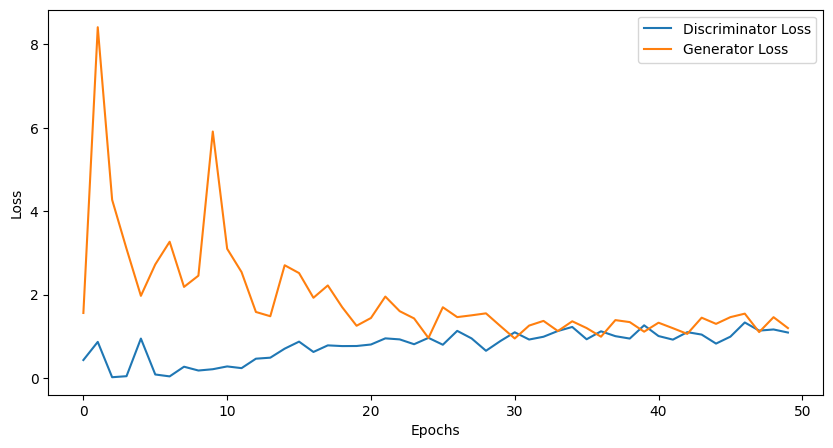

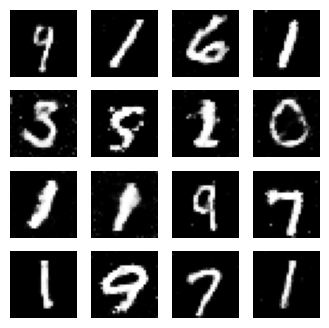

In [10]:
# Plot the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Generate and display some images
noise = tf.random.normal([16, 100])
generate_and_save_images(generator, epochs, noise)
